## Using Machine Learning

The overarching problem FEMA has, as discussed in our story telling and the initial proposal, is that that too often don't seem to know what they're dealing with when disaster strikes. Using machine learning techniques, we will do our best to help FEMA get their footing when a disaster emerges.

There are a few ways in which we can apply machine learning techniques to this OpenFEMA data, both supervised and unsupervised. When we look back at our original objective, it was 3-fold.

1) Predict expenses for a disaster

2) Group regions (zip codes) in a way that is helpful and meaningful

3) (Ultra-ambitious) Predict disasters using the features available

Now, the first two objectives fit into our machine-learning wheelhouse nicely, the first as a supervised learning problem for which we can use linear regression, the second as an unsupervised learning problem for which we can use K-Means clustering. The third problem initially seems as though it would also be a regression problem, but as we'll see later in this notebook, such an objective is absurdly outside of the scope of this project.

In [1]:
# import necessary packages

%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import scipy.stats as stats
import sklearn

import warnings
warnings.filterwarnings(action='ignore')

from IPython.display import HTML

In [2]:
# set plotting parameters

from matplotlib import rcParams
import matplotlib as mpl

blue = '#3498DB'
gray = '#95A5A6'
red = '#E74C3C'
dark_gray = '#34495E'
green = '#2ECC71'
purple = '#9B59B6'
flatui = [blue, gray, red, dark_gray, green, purple]

# Patches
mpl.rc('patch', 
       linewidth=0.5, 
       facecolor=dark_gray, 
       edgecolor='w', 
       force_edgecolor=True, 
       antialiased=True)    
  
# Figure
mpl.rc('figure', 
       figsize= (15, 6),
       facecolor='w', 
       edgecolor='w', 
       titlesize='xx-large',
       titleweight=700)

# Grid
mpl.rc('grid', 
       color=dark_gray,
       alpha=0.5, 
       linewidth=0.5, 
       linestyle='-')

# Axes
mpl.rc('axes', 
       facecolor='w',
       edgecolor=dark_gray,
       linewidth=0.5,
       grid=True,
       titlesize='large',
       labelsize='large',
       labelcolor=dark_gray,
       axisbelow=True)

mpl.rc('axes.spines',
       right=False,
       top=False)

# Ticks
mpl.rc('xtick', 
       direction='out',
       color=dark_gray)

mpl.rc('xtick.major', 
       size=0.0)

mpl.rc('xtick.minor', 
       size=0.0)

mpl.rc('ytick', 
       direction='out',
       color=dark_gray)

mpl.rc('ytick.major', 
       size=0.0)

mpl.rc('ytick.minor', 
       size=0.0)

mpl.rc('legend', 
       frameon=False,
       numpoints=1,
       scatterpoints=1)

mpl.rc('font', 
       size=13,
       weight=400,
       family='sans-serif')

rcParams['font.sans-serif']: ['Helvetica', 'Verdana', 'Lucida Grande']

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

In [3]:
# After executing the "Wrangling" code for my capstone, the following df was be stored locally as 'FEMA.csv'
file = "FEMA.csv"
dates = ['declarationDate','incidentBeginDate','incidentEndDate','disasterCloseOutDate']
df = pd.read_csv(file, sep = '\t', index_col = ['disasterNumber', 'zipCode', 'city'], parse_dates = dates, low_memory = False)

# similarly for the aggregate data
file = "aggregate_FEMA.csv"
agg_df = pd.read_csv(file, sep = '\t', parse_dates = dates, index_col = ['disasterNumber'], low_memory = False)
agg_df['disasterLength'] = agg_df['disasterLength'].str.split(expand = True)
agg_df['disasterLength'] = pd.to_numeric(agg_df['disasterLength'], errors = 'coerce')
agg_df['disasterLength'] = agg_df['disasterLength'].fillna(agg_df.disasterLength.mean())

# and aggregated zipcode data
file = "zipcodes.csv"
zip_df = pd.read_csv(file, sep = '\t', index_col = 'zipCode')
zip_df.head()

,dis_freq,validRegistrations,totalInspected,approvedForFemaAssistance,totalApprovedIhpAmount
zipCode,,,,,
00007,1,1.0,1.0,0.0,0.0
00012,1,1.0,0.5,0.5,250.0
00013,1,1.0,0.0,0.0,0.0
00015,1,3.0,2.0,2.0,1971.0
00016,1,1.0,1.0,0.0,0.0


### Supervised Learning with Linear Regression

Our origial objective that might be achieved via machine learning--more specifically through supervised learning--was to predict costs for disasters.  We can technically use linear regression to establish some predictive analytics for our metric of cost, 'total approved IHP amount'. However, it is VERY important to note that the features available to us are for the most part only available to anyone after the disaster has already occured.

Nonetheless, this is a chance to demonstrate linear regression. First, let's check for strong correlations. Though some are bound to be strong, it will be crucial to ignore some of our features that are intuitively strongly correlated purely because they are functions of one another.

In [4]:
agg_df.corr().loc[:,['totalApprovedIhpAmount']].sort_values('totalApprovedIhpAmount',ascending = False).iloc[[0,2,5,7,13],:]

,totalApprovedIhpAmount
totalApprovedIhpAmount,1.000000
totalMaxGrants,0.959074
approvedForFemaAssistance,0.827745
totalInspected,0.737784
zip_counts,0.445339


In [5]:
amt = agg_df[['totalApprovedIhpAmount','approvedForFemaAssistance',
                      'totalInspected','zip_counts','totalMaxGrants','incidentType','disasterLength']]

The features we have selected here are purposeful:

__totalApprovedIhpAmount__: this is our output variable, our 'y', that represents the money FEMA pays out through its Individual and Housing Assistance Program <br>
__totalMaxGrants__: a count of 30k+ dollar grants FEMA distributed <br>
__zip_counts__: this is our measure of spread, how expansive any disaster might have been <br>
__totalInspected__: count of number of homes inspected, a gauge of effected population <br>
__approvedForFemaAssistance__: a function of totalInspected, but a more accurate gauge of effected population <br>
__incidentType__: categorical, a description of the type of disaster (e.g. Flood, Hurricane etc.) <br>
__disasterLength__: number of days from recorded start date recorded to end date<br>

Critically, some of these variables aren't purely financial. Zip counts, total inspected and total approved, incident type, and disaster length are measures are our best bet for actually helping with any type of predictive analytics that's worth anything.

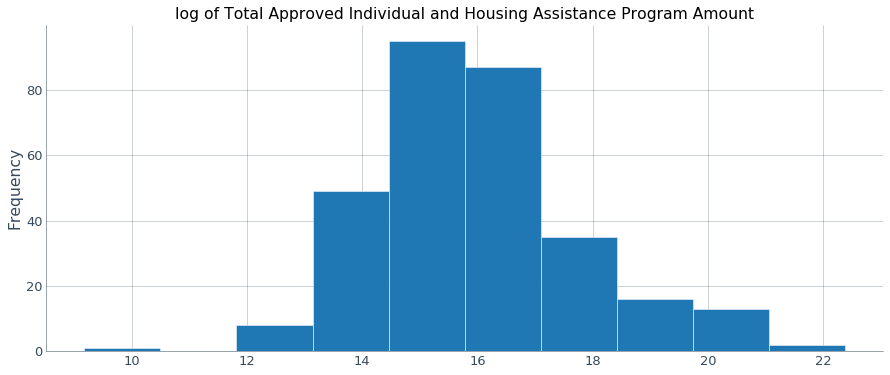

In [6]:
plt.hist(np.log(amt.totalApprovedIhpAmount))
plt.title('log of Total Approved Individual and Housing Assistance Program Amount')
plt.ylabel('Frequency')
plt.show()

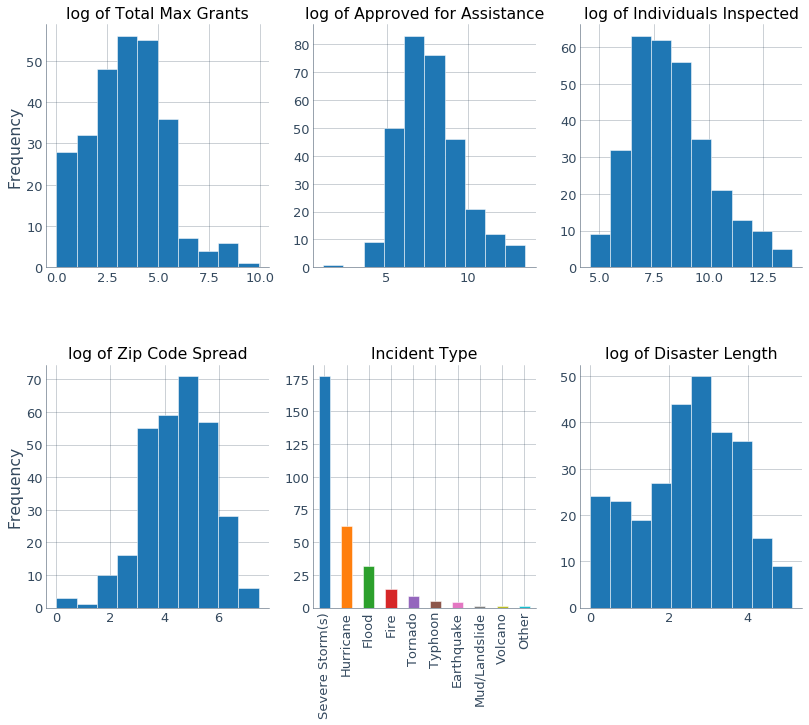

In [7]:
plt.subplots(2,3, figsize=(15,12))

plt.subplot(231)
plt.hist(np.log(amt[amt['totalMaxGrants'] > 0].totalMaxGrants))
plt.title('log of Total Max Grants')
plt.ylabel('Frequency')

plt.subplot(232)
plt.hist(np.log(amt.approvedForFemaAssistance))
plt.title('log of Approved for Assistance')

plt.subplot(233)
plt.hist(np.log(amt.totalInspected))
plt.title('log of Individuals Inspected')

plt.subplot(234)
plt.hist(np.log(amt.zip_counts))
plt.title('log of Zip Code Spread')
plt.ylabel('Frequency')

plt.subplot(235)
amt.incidentType.value_counts().plot(kind = 'bar')
plt.title('Incident Type')

plt.subplot(236)
plt.hist(np.log(amt[amt['disasterLength'] > 0].disasterLength))
plt.title('log of Disaster Length')

plt.subplots_adjust(left=0.2, wspace=0.2, hspace=0.4, top=0.8)
plt.show()

When we plot the natural logs of our features, we get, for the most part, normally distrubted data with which to work, as seen above. Because our data looks so much better this way, we'll create a "log dataframe" from which to draw features for our linear regression.

In [8]:
logamt = pd.DataFrame()

logamt['AMT'] = np.log(amt.totalApprovedIhpAmount)
logamt['GRANTS'] = np.log(amt[amt['totalMaxGrants'] > 0].totalMaxGrants)
logamt['APPR'] = np.log(amt.approvedForFemaAssistance)
logamt['INSP'] = np.log(amt.totalInspected)
logamt['ZIPS'] = np.log(amt.zip_counts)
logamt['TYPE'] = agg_df.incidentType
logamt['LENGTH'] = np.log(amt[amt['disasterLength'] > 0].disasterLength)

logamt.head()

,AMT,GRANTS,APPR,INSP,ZIPS,TYPE,LENGTH
disasterNumber,,,,,,,
1539,19.154082,4.976734,11.655457,12.074260,6.350886,Hurricane,2.944439
1541,16.441257,NaN,8.287528,8.513988,1.791759,Typhoon,1.386294
1544,16.032163,1.386294,8.087025,8.306225,4.356709,Severe Storm(s),2.079442
1545,19.831019,5.176150,12.330310,12.665754,6.981006,Hurricane,3.526361
1546,16.871708,2.564949,8.958926,9.362375,5.416100,Hurricane,1.609438


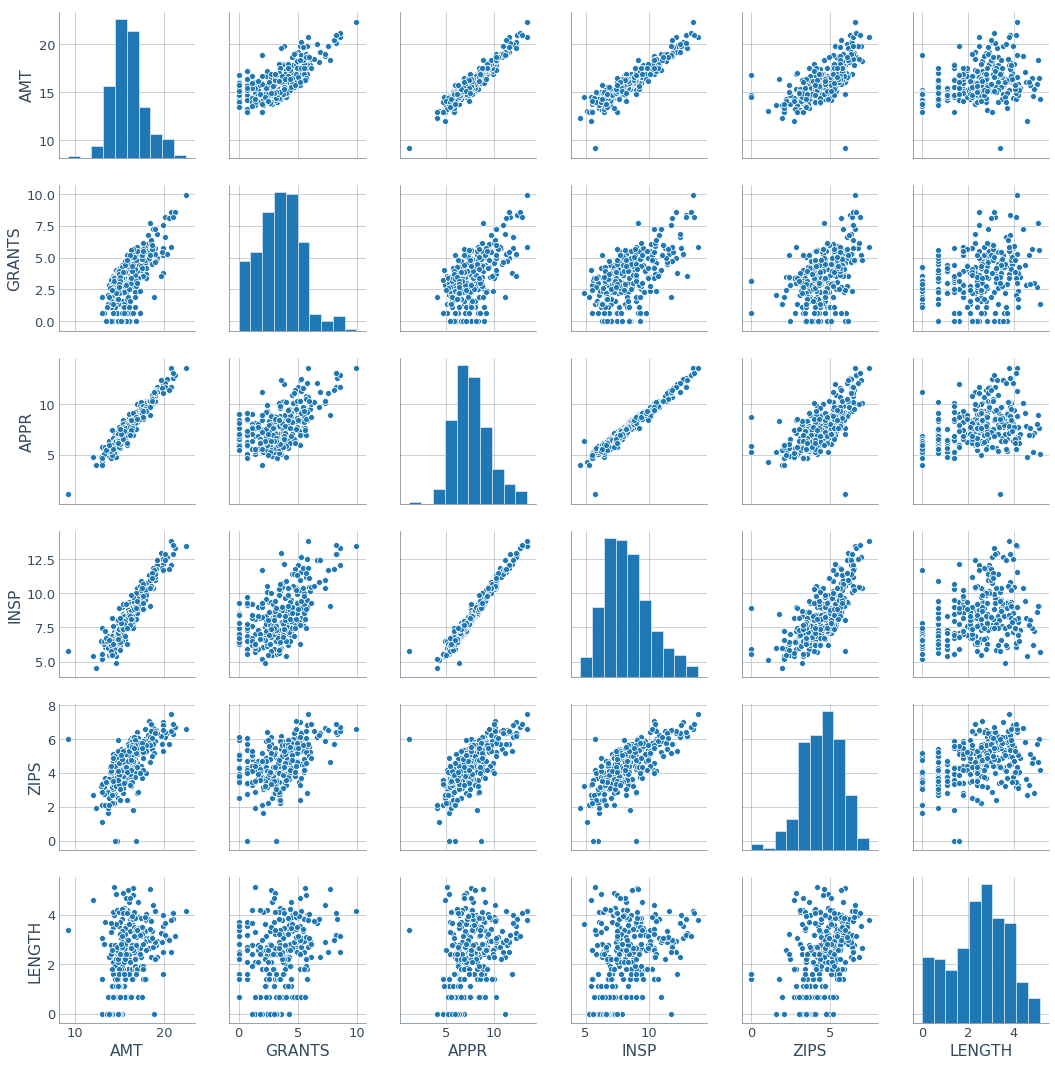

In [9]:
sns.pairplot(logamt, vars = ['AMT','GRANTS','APPR','INSP','ZIPS','LENGTH'])
plt.show()

y = total approved Individual and Housing Assistance amount, essentially how much FEMA approved to be paid out for the disaster (called "target" data in python, and referred to as the dependent variable or response variable)

and

X = all the other features (or independent variables, predictors or explanatory variables)

which we will use to fit a linear regression model and predict total approved IHP amount. We will use the least-squares method to estimate the coefficients.

In [10]:
# Import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols

### Explaining Our Models

We'll be looking at predicting FEMA's costs, signified by the feature 'Total Approved IHP Amount', after disaster strikes. Our available features allow us to predict immediately after a disaster strikes, though predict even better after a disaster has run its course. Both models are valuable, as the former is ready more readily, and the latter ought to be more accurate.<br><br>
Our first model will rely only on the incident type and the count of zip codes. If FEMA can get a ball park on how expansive the disaster is and can simply identify the type of disaster, this model would let them predict their costs.<br><br>
Our second model will rely on the aforementioned features, but also the effected home count (signified in our total inspected homes feature) and the length of the disaster in days. This new information ought to add a lot, but isn't available until the disaster has more or less run its course.




Model 1 : Predict Amount Spent Given Spread, Type, and Population
                            OLS Regression Results                            
Dep. Variable:                    AMT   R-squared:                       0.562
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     37.87
Date:                Wed, 03 Jul 2019   Prob (F-statistic):           2.69e-47
Time:                        14:01:10   Log-Likelihood:                -487.02
No. Observations:                 306   AIC:                             996.0
Df Residuals:                     295   BIC:                             1037.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

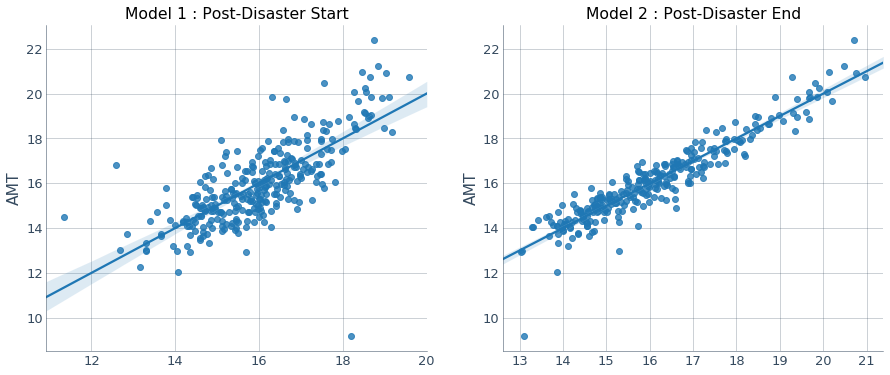

In [38]:
m_1 = ols('AMT ~ ZIPS + TYPE', logamt).fit()

m_2 = ols('AMT ~ ZIPS + TYPE + INSP + LENGTH', logamt).fit()

print('Model 1 : Predict Amount Spent Given Spread, Type, and Population')
print(m_1.summary())

print('\n \n Model 2 : Predict Amount Spent Given Spread, Type, Population, and Disaster Length')
print(m_2.summary())

plt.subplots(nrows = 1, ncols = 2)
plt.subplot(121)
sns.regplot(x = m_1.fittedvalues, y = 'AMT', data = logamt, fit_reg = True)
plt.title('Model 1 : Post-Disaster Start')

plt.subplot(122)
sns.regplot(x = m_2.fittedvalues, y = 'AMT', data = logamt[logamt.LENGTH.notnull()], fit_reg = True)
plt.title('Model 2 : Post-Disaster End')

plt.show()

#### Interpreting Summary Tables

Let's focus on the coefficient table (middle table). For both of these models, we're considering the incident type (e.g. Hurricane vs. Mudslide etc.) which is of course categorical and means we have a lot of possible coefficients. In the first model, our spread feature (zip counts) holds statistical significance as a predictor of costs, but not in the second. Similarly, some but not all of our types from the categorical variable 'incident type' hold statistical significance with low p-values.

More intuitively, just observing the plots shows us what we predicted would happen: predicting immediately upon disaster strike limits our feature choices, but is possible. Predicting once we have features of length and home count may mean we are forced to wait, but is much more significant.

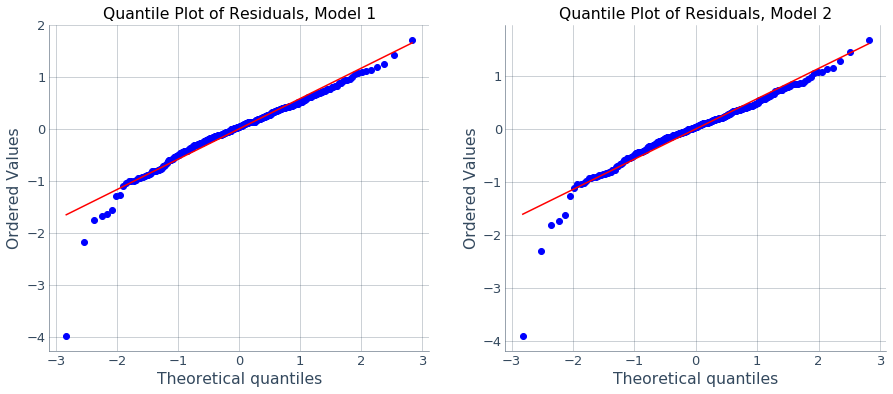

In [37]:
import pylab
# quantile plot of residuals
plt.subplots(nrows = 1, ncols = 2)

plt.subplot(121)
stats.probplot(m_1.resid, plot=pylab)
plt.title('Quantile Plot of Residuals, Model 1')

plt.subplot(122)
stats.probplot(m_2.resid, plot = pylab)
plt.title('Quantile Plot of Residuals, Model 2')
plt.show()

Our QQ plot here show the residuals are normally distributed. The R-squared, at 0.696, could be higher, and we have stronger correlating features, but so many of them are only strong because of how they factor into our AMT output variable. Upon initial inspection of correlation values, we could've picked 5 other features that correlated stronger than zip counts, but it would've been inconsequential, only telling us things we already knew--as FEMA spends more money, its total money spent increases. Ground-breaking.

For kicks, we can consider all of our features: Max-level Grants, total homes inspected, total homes approved, zip code count, and the categorical variable of disaster type. Our R-squared value is certainly nice at 0.983, but a few of our coefficients lose some meaning by shifting to negative, meaning colinearity makes them bad selections as features.

### Unsupervised Learning with K-means Clustering

   #### Clustering Zip Codes

The following code set up the unique zip code dataframe and then saved it to a csv file which we loaded in at the top of this notebook. The code used to establish how many unique disasters each zip code saw over the course of the years the original data runs (20 years), was the loop seen in lines 10 - 16 of this code block. Interestingly, in running this code, I learned that such a loop must not be especially pythonic as it took over 20 minutes to complete...

In [15]:
# zip_df = df.reset_index()[['zipCode','disasterNumber','disasterLength','validRegistrations', 'totalInspected', 'noFemaInspectedDamage', 
#                           'approvedForFemaAssistance', 'totalApprovedIhpAmount','repairReplaceAmount','rentalAmount', 
#                           'otherNeedsAmount', 'averageFemaInspectedDamage','totalDamage','fyDeclared','disasterType', 
#                           'incidentType', 'title', 'ihProgramDeclared', 'iaProgramDeclared', 'paProgramDeclared', 
#                           'hmProgramDeclared', 'incidentBeginDate', 'incidentEndDate', 'disasterCloseOutDate', 
#                           ]]
#
# zip_df = zip_df.set_index('zipCode').iloc[:,2:12].groupby('zipCode').mean() # variables for which we need a mean aggregate
#
# zc_list = zip_df.index
# dis_counts = []
#
# for zc in zc_list:
#    a = df.reset_index().set_index('zipCode').loc[str(zc),:]
#    count = len(pd.Series(a.disasterNumber).unique())
#    dis_counts.append(count)
#
# this is our measure of "frequency" for any one zipcode--how many disasters have affected it
#
# zip_df['dis_freq'] = dis_counts
#
# zip_df = zip_df[['dis_freq','validRegistrations','totalInspected','approvedForFemaAssistance',
#                 'totalApprovedIhpAmount',]]
#
# zip_df.sort_values('dis_freq',ascending = False).head()
#
# zip_df.to_csv('zipcodes.csv', sep = '\t')

As we'll see later, the data in this groupby-dataframe is unsurprisingly terrible to plot as it all hugs x = 0. With that in mind, we took the log of each column of the zip df and our variables look night-and-day better. Those transformed histograms and the necessary code are below:

In [16]:
log_cols = []
for col in zip_df.columns:
    log = np.log(zip_df[str(col)])
    log_cols.append(log)

logdf = pd.DataFrame({'log_freq': log_cols[0],
              'log_regi': log_cols[1],
              'log_insp': log_cols[2],
              'log_appr': log_cols[3],
              'log_tota': log_cols[4]}).replace(-np.inf,0)

# remove zeroes that are, for the most part, errors

editlog = logdf[(logdf.log_freq > 0) & (logdf.log_regi > 0) & (logdf.log_insp > 0) & (logdf.log_appr > 0) & (logdf.log_tota > 0)]
print(str(len(editlog)) + ' records remaining upon edit.')


11143 records remaining upon edit.


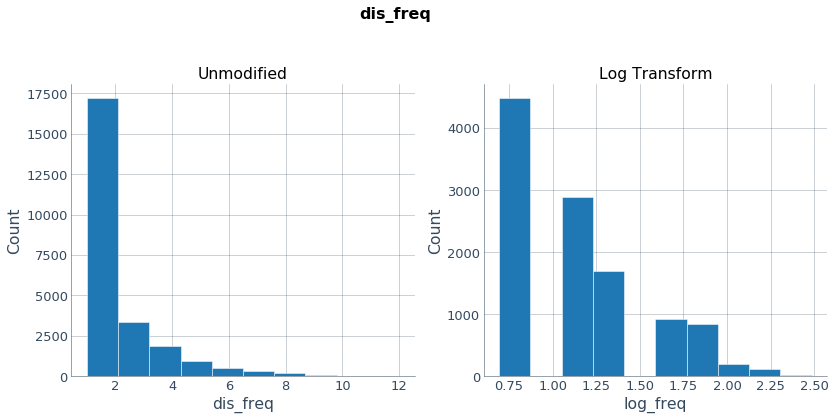

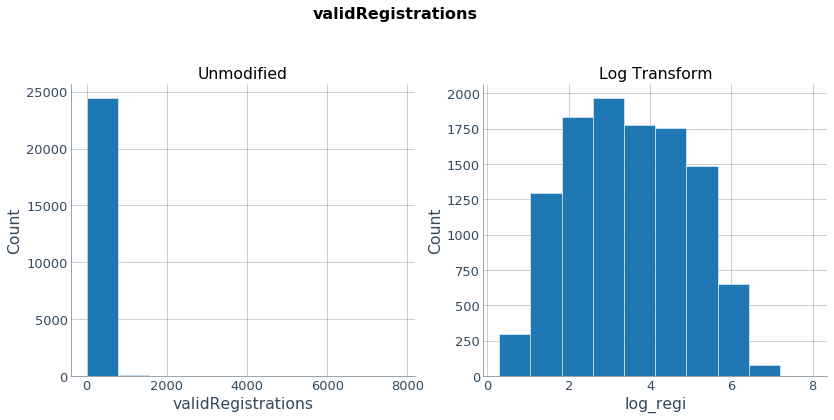

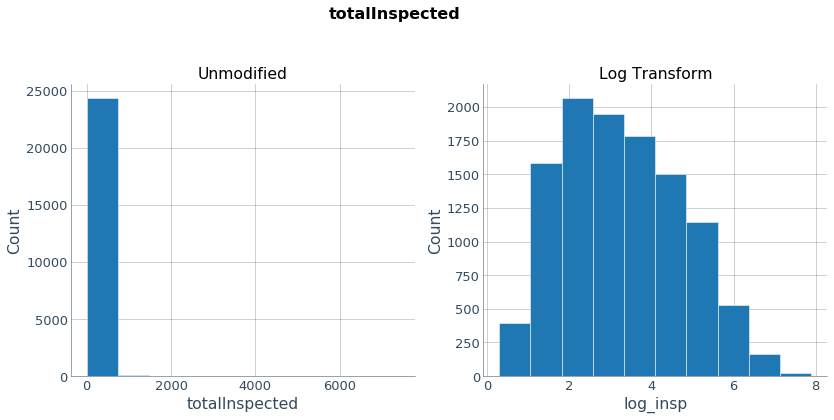

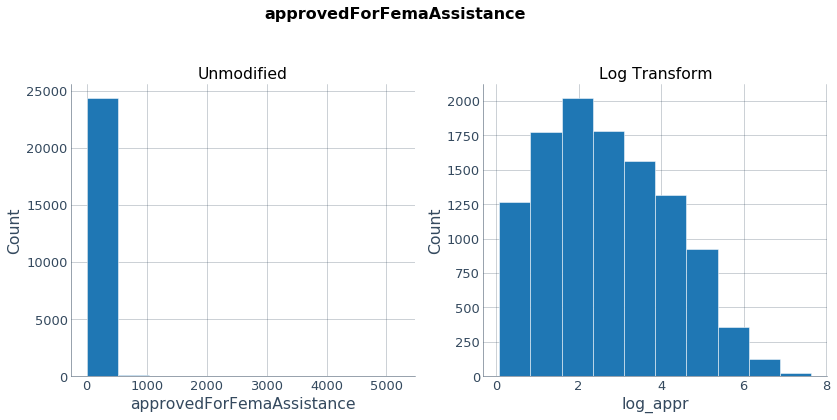

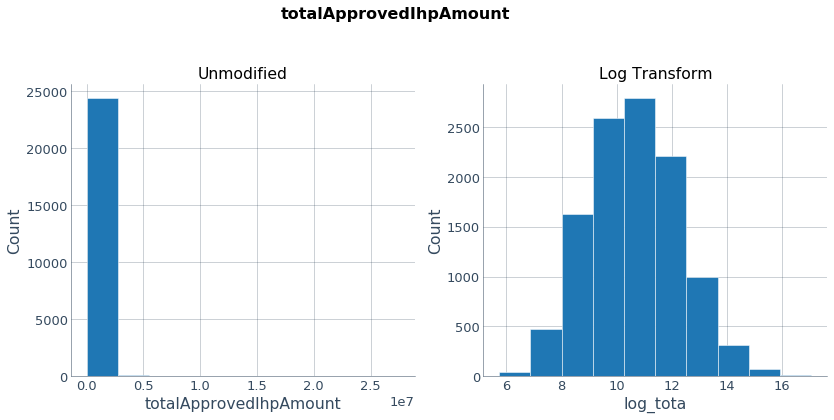

In [17]:
for i in range(5):

    plt.subplots(1,2)

    plt.subplot(121)
    plt.hist(zip_df.iloc[:,i])
    plt.title("Unmodified")
    plt.xlabel(str(zip_df.columns[i]))
    plt.ylabel("Count")

    plt.subplot(122)
    plt.hist(editlog.iloc[:,i])
    plt.title("Log Transform")
    plt.xlabel(str(editlog.columns[i]))
    plt.ylabel("Count")

    plt.suptitle(str(zip_df.columns[i]), fontsize=16)

    plt.subplots_adjust(left=0.2, wspace=0.2, top=0.8)

    plt.show()

By transforming and subsetting the data and applying the condition of '> 0', notice how we've changed our features from absolutely miserable to observe in a histogram, to approximately normal in many instances. Now we're set up to run a Principal Component Analysis (PCA) and subsequently cluster.

In [18]:
#x_cols = logdf[['log_freq', 'log_regi', 'log_insp', 'log_appr', 'log_tota']]
x_cols = editlog
#x_cols.disasterlength = x_cols.disasterLength.fillna(x_cols.disasterLength.mean(), inplace = True)

In [19]:
# can't have any null values when we try to run PCA, so let's check 

print('NaN count : ', str(x_cols.isnull().sum().sum()))
x_cols.shape

NaN count :  0


(11143, 5)

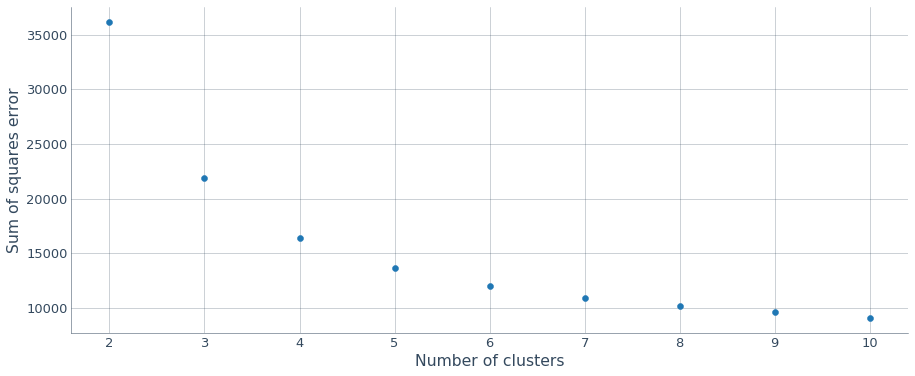

In [20]:
from sklearn.cluster import KMeans

SS = []

for k in range(2, 11):
    kmeans_cluster = KMeans(n_clusters = k, random_state=23).fit(x_cols)
    SS.append(kmeans_cluster.inertia_)

plt.scatter(range(2,11), SS)
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squares error")
plt.show()

Our sum of squares error starts to level out at either 3 or 4 clusters. Because I know our end result is not likely in the slightest to be clean clustered groups, I set the cluster count to variable 'n' and ran a few different possibilities, ultimately landing on 4, though it isn't decidedly better than 3.

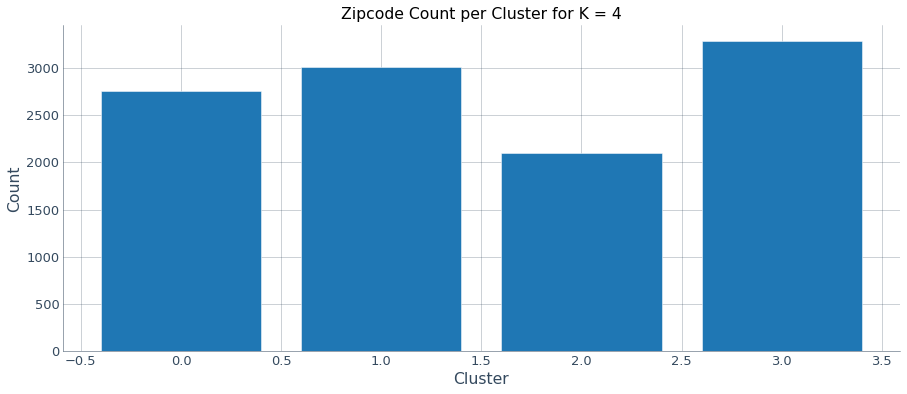

In [21]:
n = 4

kmeans_cluster = KMeans(n_clusters = n, random_state=23).fit(x_cols)

counts = [0 for i in range(n)]
for i in range(n):
    for label in kmeans_cluster.labels_:
        if label == i:
            counts[i] += 1

plt.bar(range(n), counts)
#plt.xticks([0,1,2])
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.title("Zipcode Count per Cluster for K = "+str(n))
plt.show()

In [22]:
# label our zip codes by cluster number

from sklearn.decomposition import PCA

pca = pd.DataFrame(PCA(n_components=2).fit_transform(x_cols))
pca.columns = ['x','y']
pca['cluster'] = pd.Series(KMeans(n_clusters=n).fit(x_cols).labels_)
pca['zipCode'] = logdf.reset_index().zipCode

pca.head()

,x,y,cluster,zipCode
0,-5.544197,-0.321477,3,00007
1,-5.698805,-0.814348,3,00012
2,3.186976,0.200401,0,00013
3,3.305099,-0.040916,0,00015
4,3.449767,-0.093397,0,00016


Once we added cluster labels to our zip code records, it was time to plot these PCA-derived clusters (seen below).

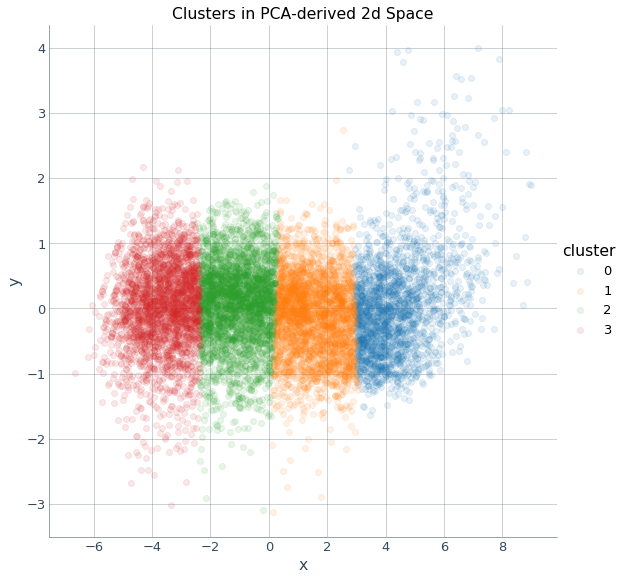

In [23]:
sns.lmplot('x','y', data = pca, hue = 'cluster', fit_reg=False, height = 8, scatter_kws={'alpha':.1})
plt.title('Clusters in PCA-derived 2d Space')
plt.show()

## Conclusions

While our clustering efforts here were "technically" successful, and at the very least correct, they do not reveal much. Just upon visual inspection, it is not hard to come to the conclusion that there really aren't distinct groups to be divided into clusters in the first place--not based on the features we have available.

Our multiple linear regression analysis falls under the same sort of assessment, though certainly stronger: successful, correct, not entirely revealing. Because so many of our features live to varying degrees under "post-disaster", they aren't helpful. However, we were able to select and create some features that could give us confidence in making predictions immediately after disaster strikes. That model gave us an R-squared of 0.562. When we consider the model that predicts costs after the disaster ends, we actually get a respectable R-squared value of 0.889. Such a metric should allow us to consider this model successful.